### Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора 
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук `parse_rospotrebnadzor.ipynb`
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать 
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики


In [1]:
! pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import string
import pymorphy2
from nltk.corpus import stopwords
from gensim.models import Word2Vec, FastText
import numpy as np
from tqdm.notebook import tqdm
import re
from multiprocessing import Pool
from pymystem3 import Mystem
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2023-02-09 20:15:34--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2023-02-09 20:15:34--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc17dc152cf09b29ed1455c56206.dl.dropboxusercontent.com/cd/0/inline/B2OXOBFU76N_eRjrlM432xHeo-vRSezCefqhkEpwsTp-ee3isiWqEydKKUHkp8lJQghfh_sMx7RsWKefkPHpE-xDVzUfP3L9X7-_alZxQ9QMIwGnzffArbnqdQtb2gGcFJixZ42yJXpcQOr_4Uz74bMmJG41-hWDJU0k8ljKFwRjGA/file# [following]
--2023-02-09 20:15:35--  https://uc17dc152cf09b29ed1455c56206.dl.dropboxusercontent.com/cd/0/inline/B2OXOBFU76N_eRjrlM432xHeo-vRSezCefqhkEpwsTp-ee3isiWqEydKKUHkp8lJQghfh_sMx7RsWKef

In [10]:
positive = pd.read_csv('positive.csv', sep=';', names=['text'], header = None, usecols = [3], encoding='UTF-8')
negative = pd.read_csv('negative.csv', sep=';', names=['text'], header = None, usecols = [3], encoding='UTF-8')
df = positive.append(negative)

In [11]:
texts = list(df['text'])

In [12]:
words_regex = re.compile('\w+')
morph = pymorphy2.MorphAnalyzer()
def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

stopwords_list = stopwords.words('russian')

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [13]:
texts = texts[0:10000]

In [14]:
preprocessed_text = list(tqdm(map(preprocess, texts), total=len(texts)))

  0%|          | 0/10000 [00:00<?, ?it/s]

## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [15]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from gensim.models import *
from gensim import corpora

In [17]:
dictionary = corpora.Dictionary(preprocessed_text)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('tweet.dict')

In [18]:
corpus = [dictionary.doc2bow(text) for text in preprocessed_text]
corpora.MmCorpus.serialize('tweet.model', corpus) 

In [19]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=10)

CPU times: user 18.8 s, sys: 96.3 ms, total: 18.9 s
Wall time: 28.3 s


In [20]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.115*"хороший" + 0.077*"человек" + 0.046*"это" + 0.045*"большой" + 0.033*"привет" + 0.029*"час" + 0.027*"ждать" + 0.024*"давать" + 0.020*"настроение" + 0.018*"маленький"'),
 (1,
  '0.133*"ещё" + 0.069*"новый" + 0.044*"ночь" + 0.039*"девочка" + 0.024*"еда" + 0.021*"хотя" + 0.020*"остаться" + 0.020*"ребята" + 0.019*"почему" + 0.019*"ваш"'),
 (2,
  '0.149*"день" + 0.090*"добрый" + 0.035*"наш" + 0.033*"друг" + 0.033*"вчера" + 0.032*"спать" + 0.027*"прийти" + 0.021*"сон" + 0.021*"рождение" + 0.019*"счастливый"'),
 (3,
  '0.069*"год" + 0.032*"выходной" + 0.029*"говорить" + 0.028*"стать" + 0.027*"правда" + 0.026*"снег" + 0.025*"песня" + 0.025*"видеть" + 0.022*"делать" + 0.019*"класс"'),
 (4,
  '0.059*"смотреть" + 0.054*"любимый" + 0.050*"дом" + 0.046*"писать" + 0.034*"жизнь" + 0.032*"никто" + 0.025*"купить" + 0.023*"девушка" + 0.022*"хотеться" + 0.021*"понять"'),
 (5,
  '0.128*"утро" + 0.058*"просто" + 0.050*"свой" + 0.038*"пойти" + 0.037*"вообще" + 0.032*"первый" + 0.031*"школа" + 0

In [21]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=8d0e0327c4ab4f63c6fe0e2cdd88a2d68ceb10a2d3830a12b48ab7286acf7197
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=705bd117d491d51dc9d3e152062b370e1067b560396356bb3d341fb474a8aab1
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [22]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


CPU times: user 936 ms, sys: 73.9 ms, total: 1.01 s
Wall time: 3.84 s


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [23]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Персплексия:  0.0009836945348685715


/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [24]:
coherence_model_lda = CoherenceModel(model=lda, texts=preprocessed_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.4758520220853056


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/5 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

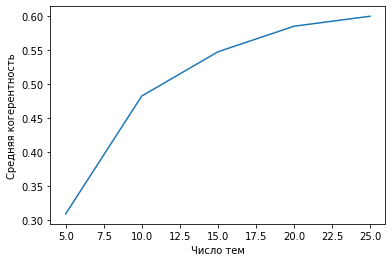

In [26]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=preprocessed_text, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [27]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for